# MSCI Indices - Download and Fill Missing Days

This notebook downloads MSCI index data from the GitHub repository and fills missing days using backward fill (bfill).


In [1]:
import pandas as pd
import os
import requests
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Change to project root directory
# Find the project root by looking for the 'data' directory
current_dir = os.getcwd()
while not os.path.exists(os.path.join(current_dir, 'data')):
    parent_dir = os.path.dirname(current_dir)
    if parent_dir == current_dir:
        # Reached filesystem root without finding 'data' directory
        raise FileNotFoundError("Could not find project root directory (looking for 'data' folder)")
    current_dir = parent_dir

os.chdir(current_dir)
print(f"Working directory: {os.getcwd()}")

Working directory: /workspace


In [3]:
# GitHub repository base URL
github_base_url = "https://raw.githubusercontent.com/amedeos/Stock-Indexes-Historical-Data/main"

# Define the files to download
files_to_download = {
    'ACWI': 'DAILY/NET/EUR/ALL-COUNTRY-DM-EM/Region/NONE/NONE/STANDARD-LARGE-MID-CAP/ACWI.csv',
    'WORLD': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Region/NONE/NONE/STANDARD-LARGE-MID-CAP/WORLD.csv',
    'ITALY': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/ITALY.csv',
    'EUROPE': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Region/NONE/NONE/STANDARD-LARGE-MID-CAP/EUROPE.csv',
    'EMU': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Region/NONE/NONE/STANDARD-LARGE-MID-CAP/EMU.csv',
    'GERMANY': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/GERMANY.csv',
    'FRANCE': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/FRANCE.csv',
    'SPAIN': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/SPAIN.csv',
    'UK': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/UK.csv',
    'NETHERLANDS': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/NETHERLANDS.csv',
    'SWEDEN': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/SWEDEN.csv',
    'DENMARK': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/DENMARK.csv',
    'NORWAY': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/NORWAY.csv',
    'FINLAND': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/FINLAND.csv',
    'SWITZERLAND': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/SWITZERLAND.csv',
    'AUSTRIA': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/AUSTRIA.csv',
    'BELGIUM': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/BELGIUM.csv',
    'PORTUGAL': 'DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/PORTUGAL.csv'
}


In [4]:
# Output directory
output_dir = 'data/msci'
os.makedirs(output_dir, exist_ok=True)

print(f"Output directory: {output_dir}")
print(f"\nFiles to download:")
for name, path in files_to_download.items():
    print(f"  {name}: {path}")

Output directory: data/msci

Files to download:
  ACWI: DAILY/NET/EUR/ALL-COUNTRY-DM-EM/Region/NONE/NONE/STANDARD-LARGE-MID-CAP/ACWI.csv
  WORLD: DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Region/NONE/NONE/STANDARD-LARGE-MID-CAP/WORLD.csv
  ITALY: DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/ITALY.csv
  EUROPE: DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Region/NONE/NONE/STANDARD-LARGE-MID-CAP/EUROPE.csv
  EMU: DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Region/NONE/NONE/STANDARD-LARGE-MID-CAP/EMU.csv
  GERMANY: DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/GERMANY.csv
  FRANCE: DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/FRANCE.csv
  SPAIN: DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/SPAIN.csv
  UK: DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/UK.csv
  NETHERLANDS: DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/NETHERLANDS.csv
 


Processing ACWI...
Download successful (size: 190622 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'ACWI']

First few rows:
         Date        ACWI
0  2000-12-29  100.000000
1  2001-01-01   99.995065
2  2001-01-02   97.601981
3  2001-01-03   99.782219
4  2001-01-04  100.060606

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date    0
ACWI    0
dtype: int64

Saved to: data/msci/ACWI.csv
Final shape: (9106, 2)
Plot saved to: data/msci/ACWI_plot.png


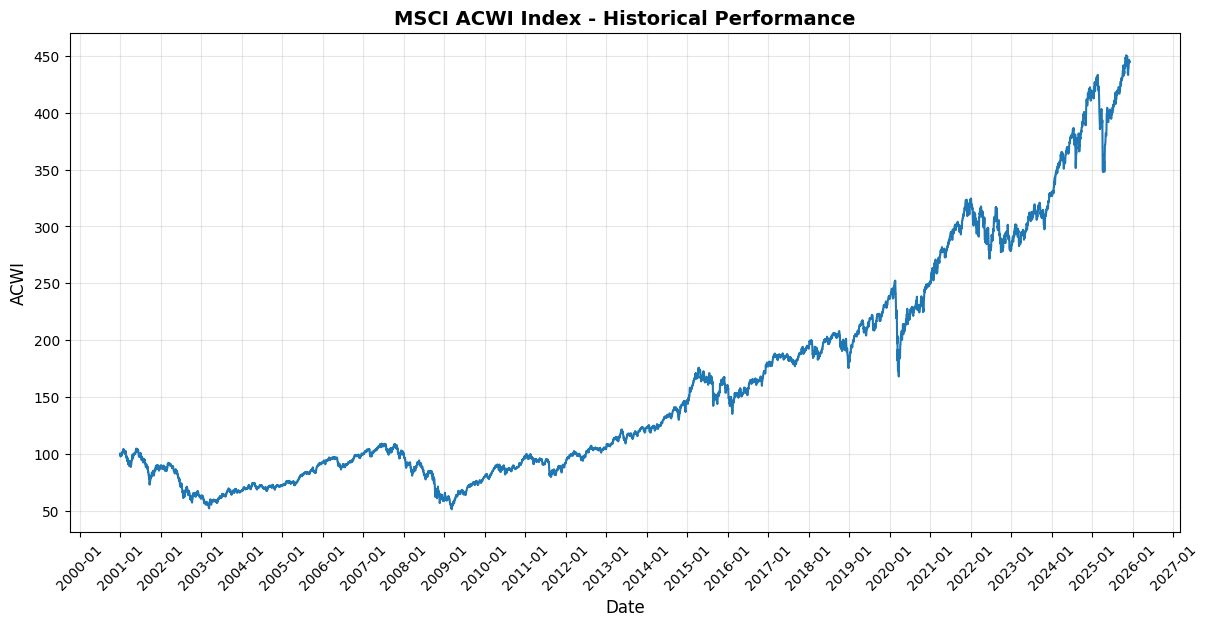


Processing WORLD...
Download successful (size: 191612 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'WORLD']

First few rows:
         Date       WORLD
0  2000-12-29  135.667607
1  2001-01-01  135.667607
2  2001-01-02  132.306010
3  2001-01-03  135.368685
4  2001-01-04  135.506591

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date     0
WORLD    0
dtype: int64

Saved to: data/msci/WORLD.csv
Final shape: (9106, 2)
Plot saved to: data/msci/WORLD_plot.png


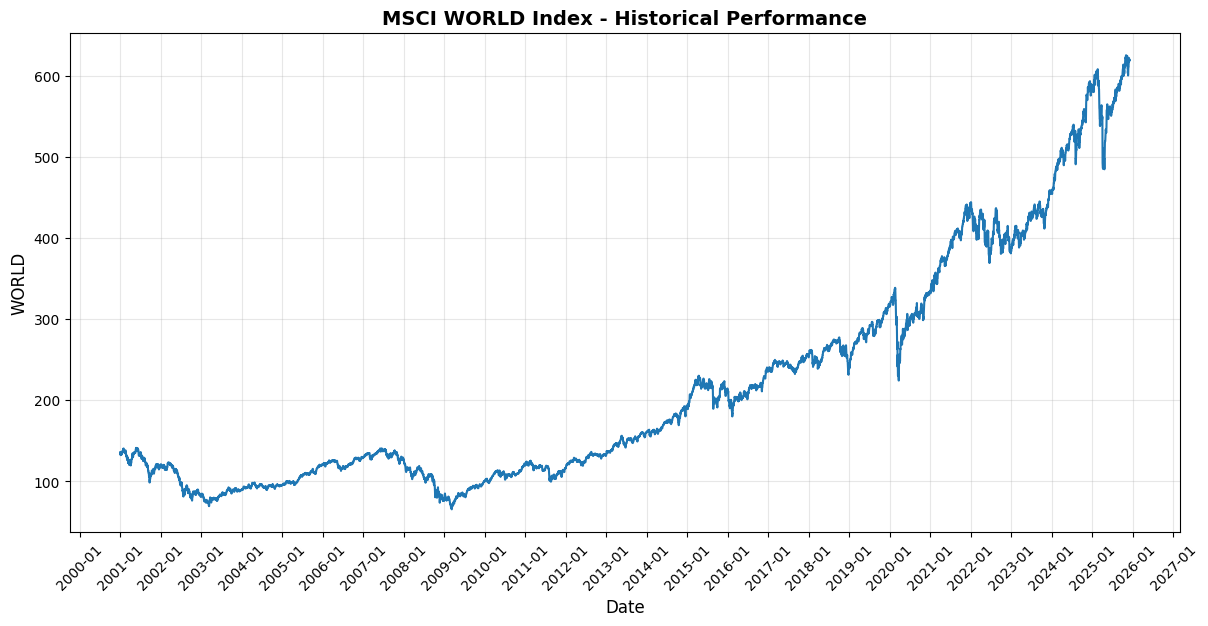


Processing ITALY...
Download successful (size: 190680 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'ITALY']

First few rows:
         Date       ITALY
0  2000-12-29  123.086156
1  2001-01-01  123.086156
2  2001-01-02  121.942426
3  2001-01-03  119.485600
4  2001-01-04  121.384858

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date     0
ITALY    0
dtype: int64

Saved to: data/msci/ITALY.csv
Final shape: (9106, 2)
Plot saved to: data/msci/ITALY_plot.png


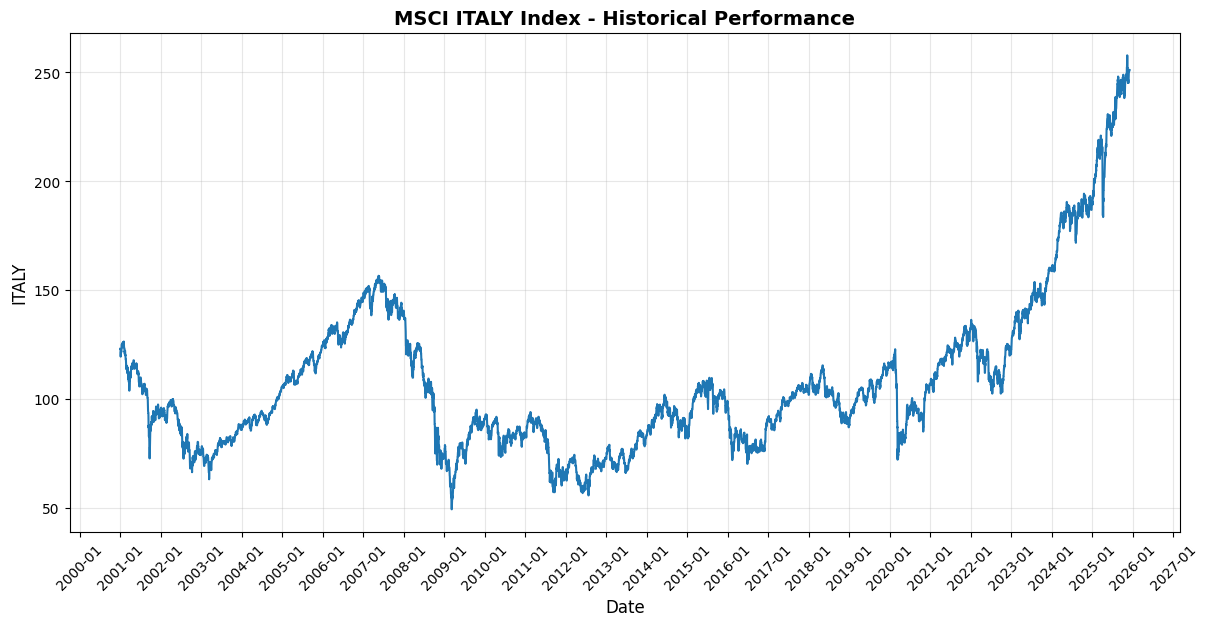


Processing EUROPE...
Download successful (size: 192119 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'EUROPE']

First few rows:
         Date      EUROPE
0  2000-12-29  132.788256
1  2001-01-01  132.788256
2  2001-01-02  130.996141
3  2001-01-03  129.510460
4  2001-01-04  131.958510

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date      0
EUROPE    0
dtype: int64

Saved to: data/msci/EUROPE.csv
Final shape: (9106, 2)
Plot saved to: data/msci/EUROPE_plot.png


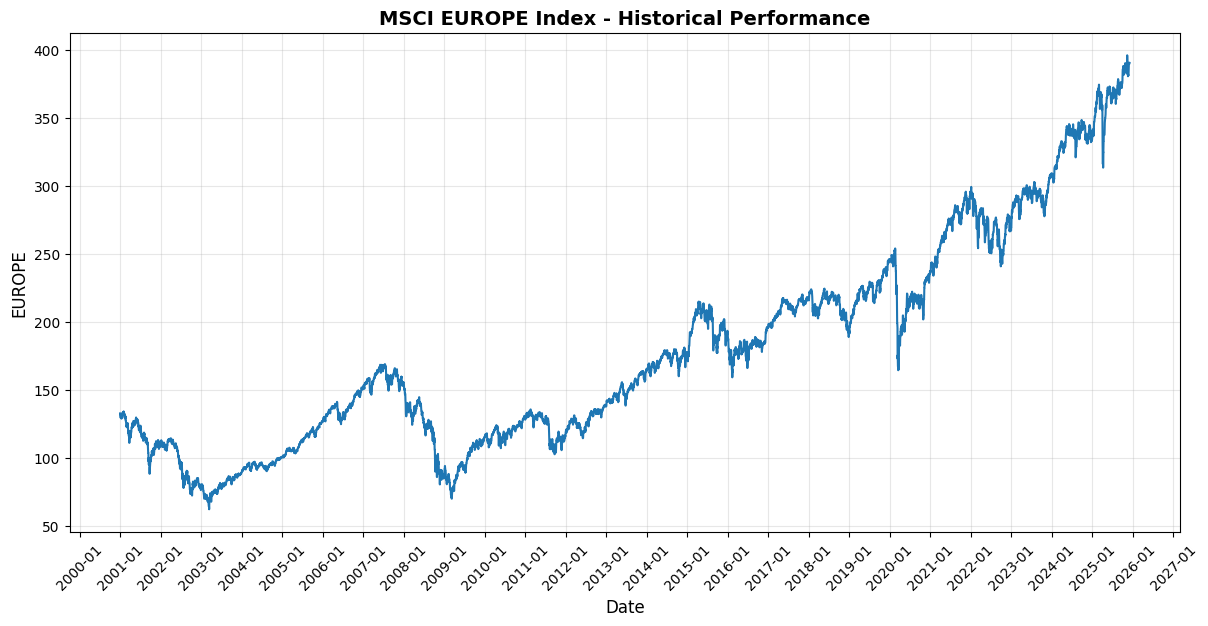


Processing EMU...
Download successful (size: 192208 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'EMU']

First few rows:
         Date         EMU
0  2000-12-29  135.588816
1  2001-01-01  135.588816
2  2001-01-02  133.562031
3  2001-01-03  132.204659
4  2001-01-04  134.744842

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date    0
EMU     0
dtype: int64

Saved to: data/msci/EMU.csv
Final shape: (9106, 2)
Plot saved to: data/msci/EMU_plot.png


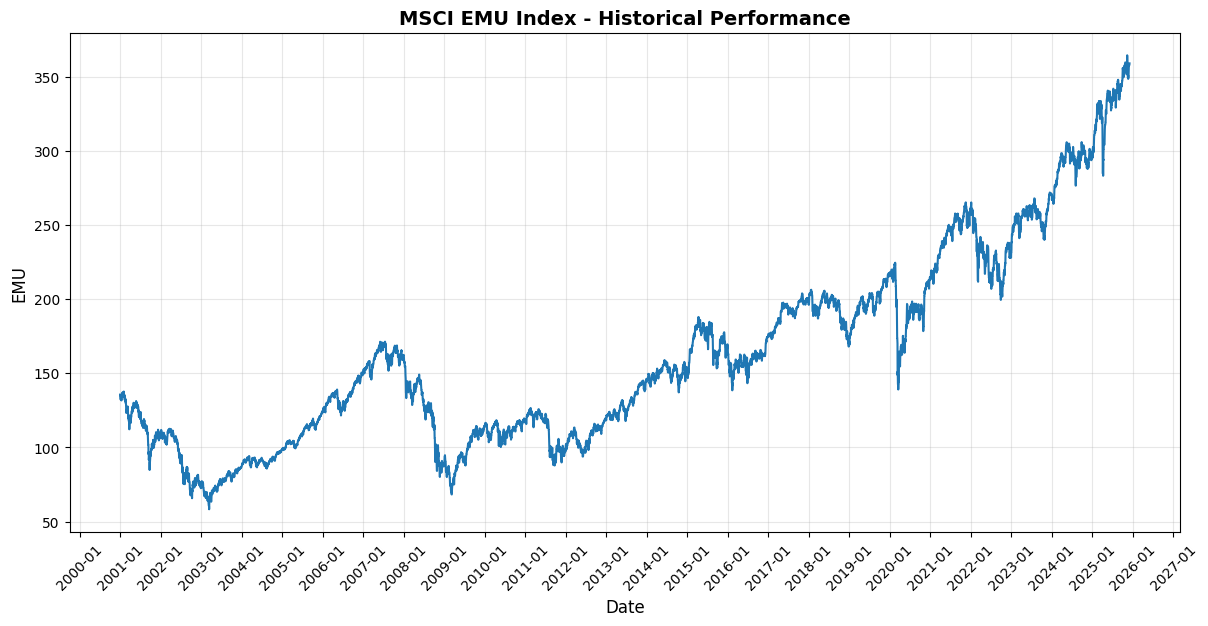


Processing GERMANY...
Download successful (size: 192055 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'GERMANY']

First few rows:
         Date     GERMANY
0  2000-12-29  126.738227
1  2001-01-01  126.738227
2  2001-01-02  124.148547
3  2001-01-03  126.456616
4  2001-01-04  125.736687

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date       0
GERMANY    0
dtype: int64

Saved to: data/msci/GERMANY.csv
Final shape: (9106, 2)
Plot saved to: data/msci/GERMANY_plot.png


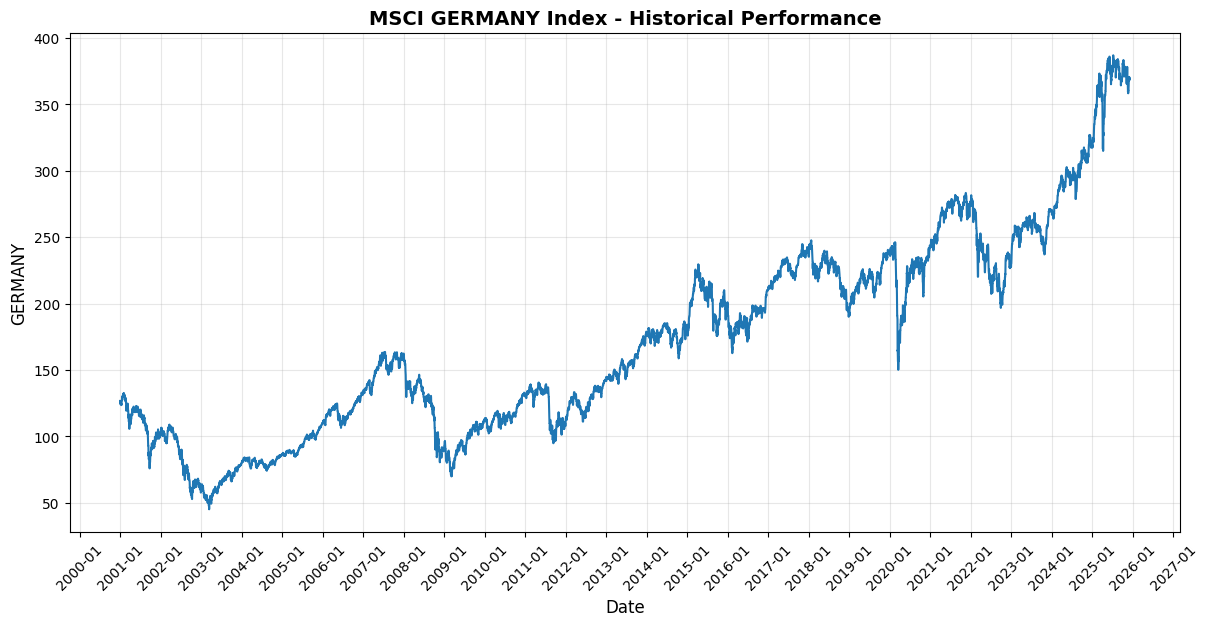


Processing FRANCE...
Download successful (size: 192364 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'FRANCE']

First few rows:
         Date      FRANCE
0  2000-12-29  154.714038
1  2001-01-01  154.714038
2  2001-01-02  151.463993
3  2001-01-03  148.429223
4  2001-01-04  151.621719

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date      0
FRANCE    0
dtype: int64

Saved to: data/msci/FRANCE.csv
Final shape: (9106, 2)
Plot saved to: data/msci/FRANCE_plot.png


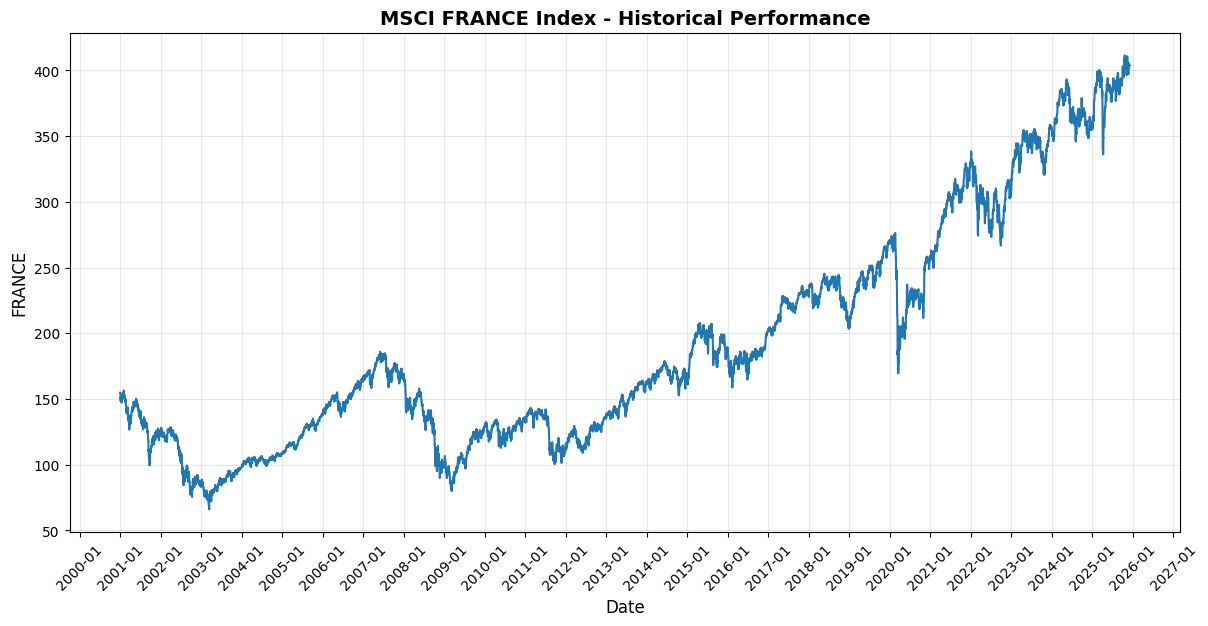


Processing SPAIN...
Download successful (size: 192528 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'SPAIN']

First few rows:
         Date       SPAIN
0  2000-12-29  110.323624
1  2001-01-01  110.323624
2  2001-01-02  110.159666
3  2001-01-03  111.928568
4  2001-01-04  116.872955

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date     0
SPAIN    0
dtype: int64

Saved to: data/msci/SPAIN.csv
Final shape: (9106, 2)
Plot saved to: data/msci/SPAIN_plot.png


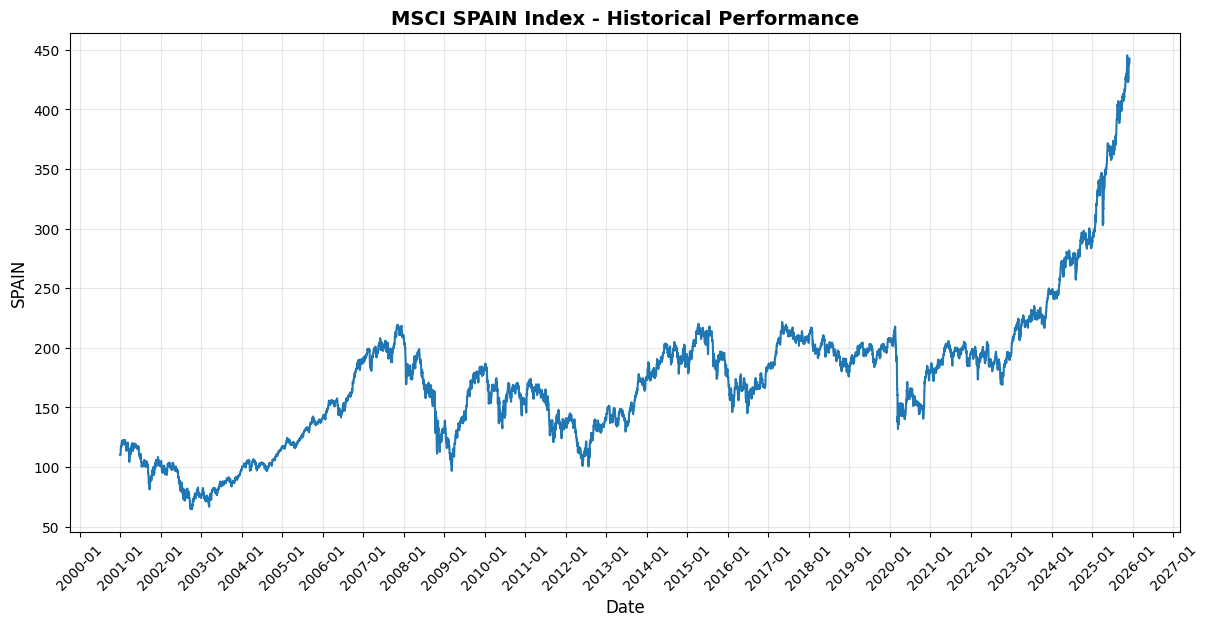


Processing UK...
Error downloading file: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/amedeos/Stock-Indexes-Historical-Data/main/DAILY/NET/EUR/DEVELOPED-MARKETS-DM/Country/NONE/NONE/STANDARD-LARGE-MID-CAP/UK.csv

Processing NETHERLANDS...
Download successful (size: 191608 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'NETHERLANDS']

First few rows:
         Date  NETHERLANDS
0  2000-12-29   128.219983
1  2001-01-01   128.219983
2  2001-01-02   127.683816
3  2001-01-03   127.158137
4  2001-01-04   128.322105

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date           0
NETHERLANDS    0
dtype: int64

Saved to: data/msci/NETHERLANDS.csv
Final shape: (9106, 2)
Plot saved to: data/msci/NETHERLANDS_plot.png


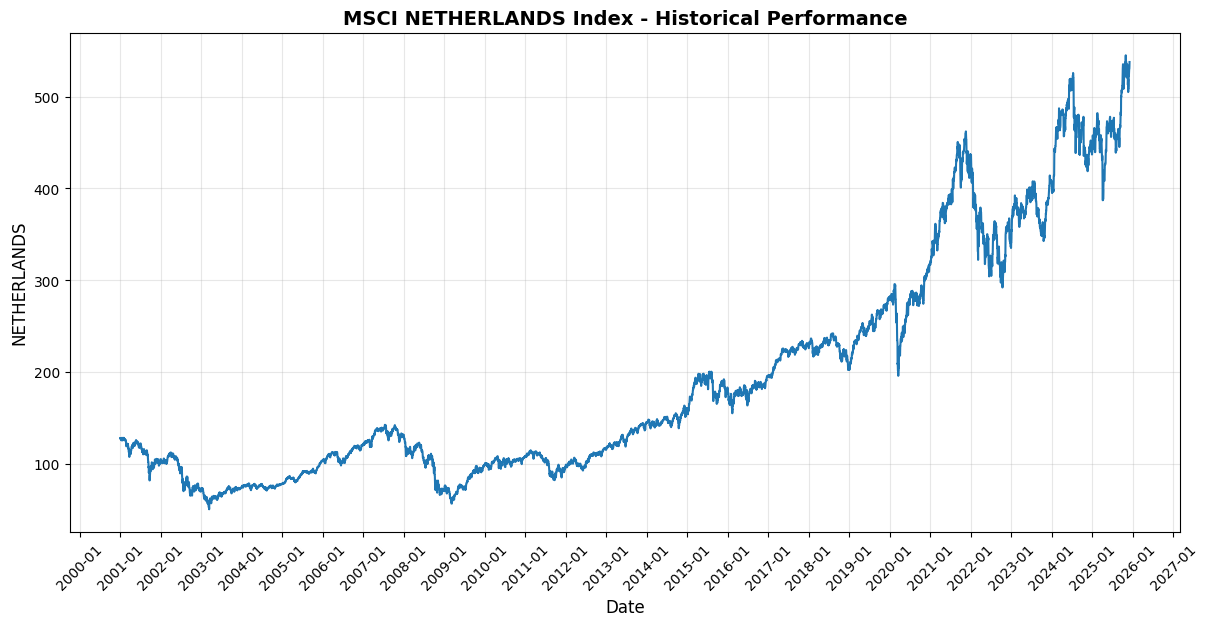


Processing SWEDEN...
Download successful (size: 191393 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'SWEDEN']

First few rows:
         Date      SWEDEN
0  2000-12-29  176.957451
1  2001-01-01  176.957451
2  2001-01-02  172.811511
3  2001-01-03  164.285382
4  2001-01-04  178.740056

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date      0
SWEDEN    0
dtype: int64

Saved to: data/msci/SWEDEN.csv
Final shape: (9106, 2)
Plot saved to: data/msci/SWEDEN_plot.png


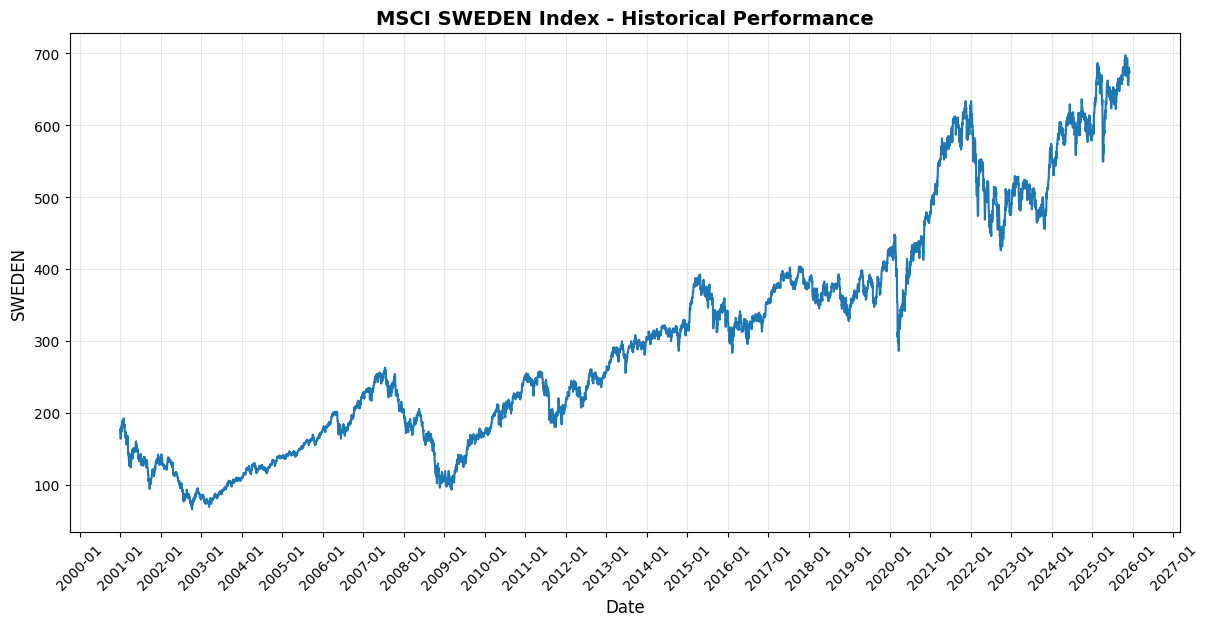


Processing DENMARK...
Download successful (size: 191284 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'DENMARK']

First few rows:
         Date     DENMARK
0  2000-12-29  144.988153
1  2001-01-01  144.988153
2  2001-01-02  146.765901
3  2001-01-03  148.563136
4  2001-01-04  150.863546

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date       0
DENMARK    0
dtype: int64

Saved to: data/msci/DENMARK.csv
Final shape: (9106, 2)
Plot saved to: data/msci/DENMARK_plot.png


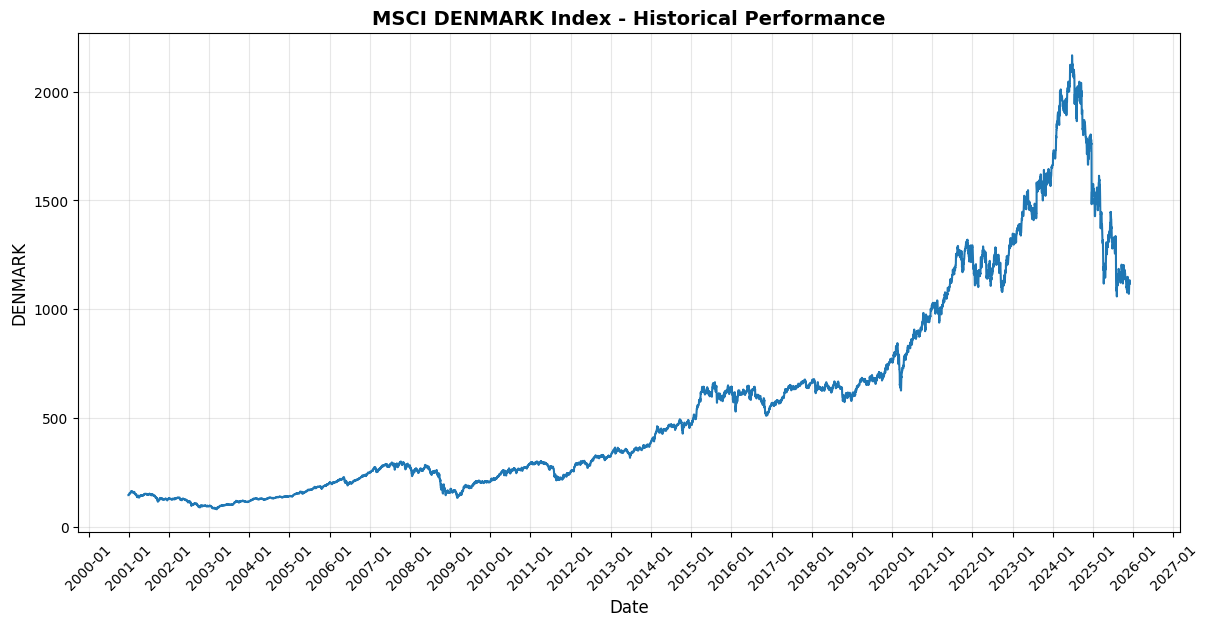


Processing NORWAY...
Download successful (size: 190918 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'NORWAY']

First few rows:
         Date      NORWAY
0  2000-12-29  163.253366
1  2001-01-01  163.253366
2  2001-01-02  166.109030
3  2001-01-03  161.069670
4  2001-01-04  164.535653

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date      0
NORWAY    0
dtype: int64

Saved to: data/msci/NORWAY.csv
Final shape: (9106, 2)
Plot saved to: data/msci/NORWAY_plot.png


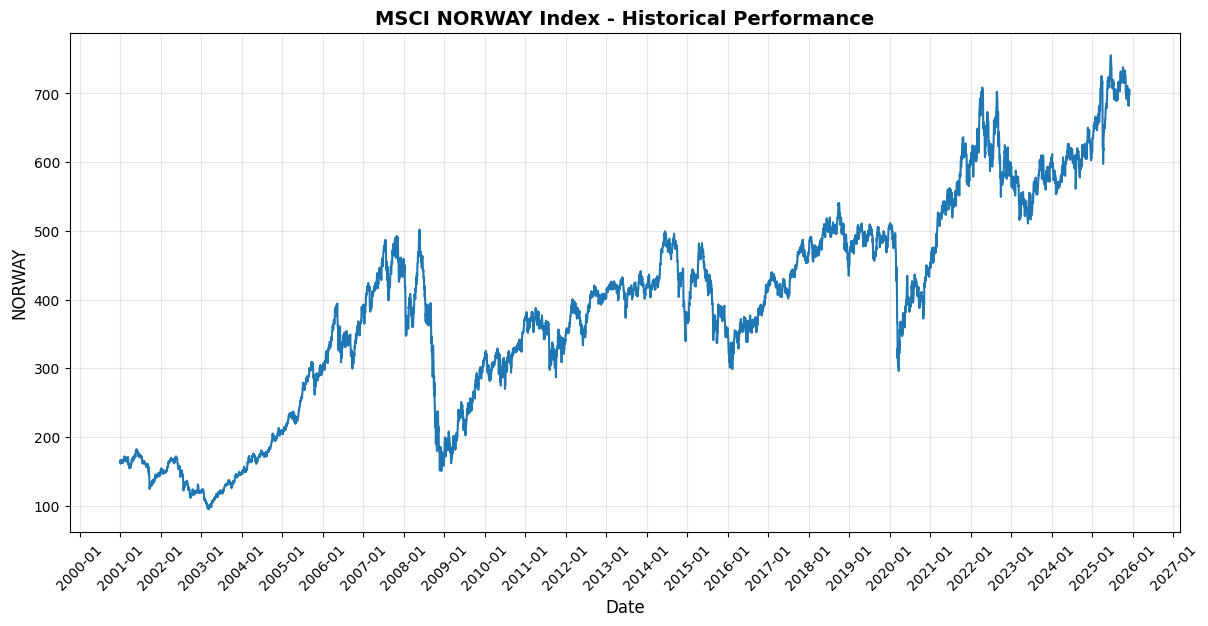


Processing FINLAND...
Download successful (size: 192608 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'FINLAND']

First few rows:
         Date     FINLAND
0  2000-12-29  271.037949
1  2001-01-01  271.037949
2  2001-01-02  262.065728
3  2001-01-03  242.152197
4  2001-01-04  266.822107

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date       0
FINLAND    0
dtype: int64

Saved to: data/msci/FINLAND.csv
Final shape: (9106, 2)
Plot saved to: data/msci/FINLAND_plot.png


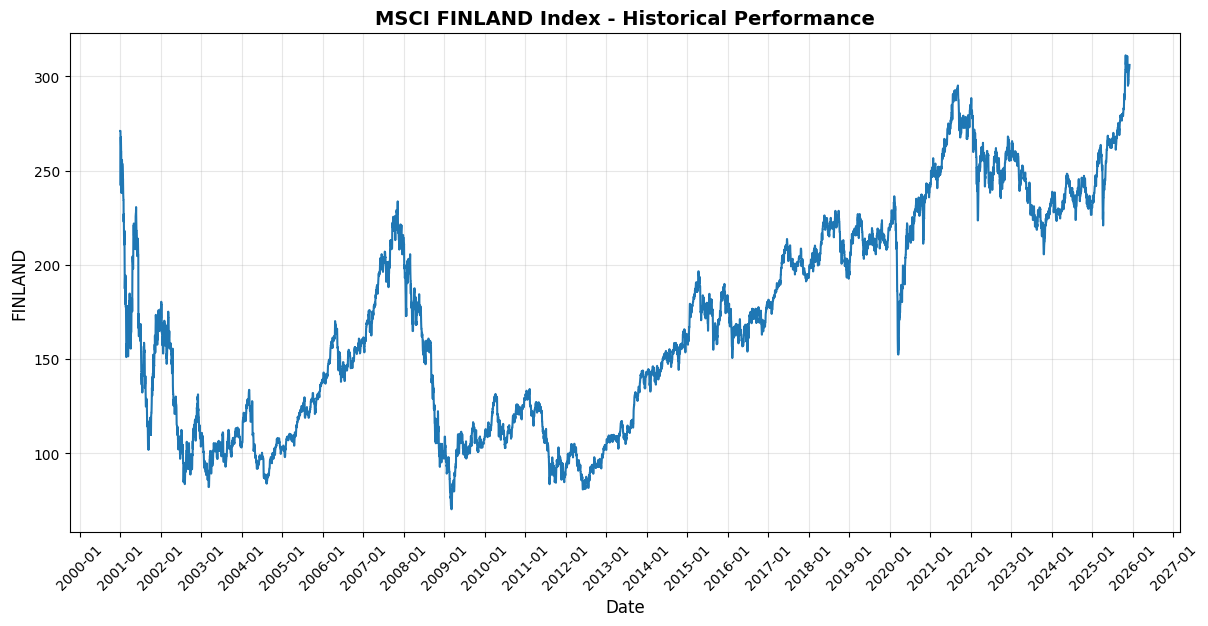


Processing SWITZERLAND...
Download successful (size: 191573 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'SWITZERLAND']

First few rows:
         Date  SWITZERLAND
0  2000-12-29   123.097698
1  2001-01-01   123.097698
2  2001-01-02   122.951510
3  2001-01-03   123.309535
4  2001-01-04   123.586933

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date           0
SWITZERLAND    0
dtype: int64

Saved to: data/msci/SWITZERLAND.csv
Final shape: (9106, 2)
Plot saved to: data/msci/SWITZERLAND_plot.png


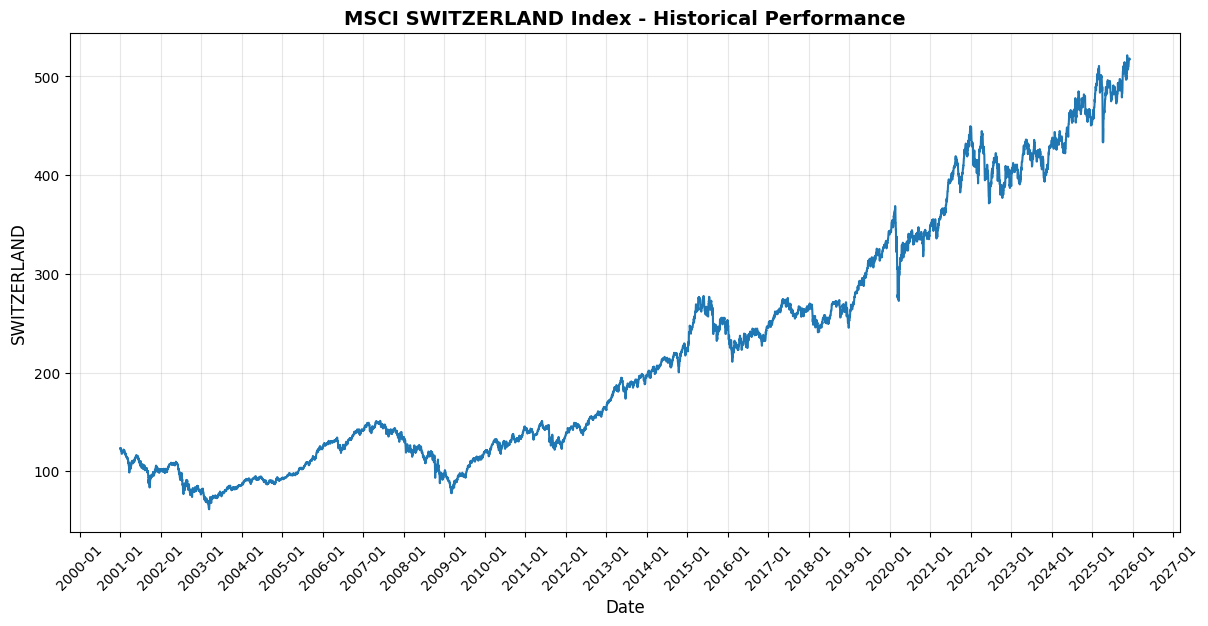


Processing AUSTRIA...
Download successful (size: 192576 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'AUSTRIA']

First few rows:
         Date     AUSTRIA
0  2000-12-29  100.082234
1  2001-01-01  100.082234
2  2001-01-02   99.824060
3  2001-01-03   98.282033
4  2001-01-04  100.049834

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date       0
AUSTRIA    0
dtype: int64

Saved to: data/msci/AUSTRIA.csv
Final shape: (9106, 2)
Plot saved to: data/msci/AUSTRIA_plot.png


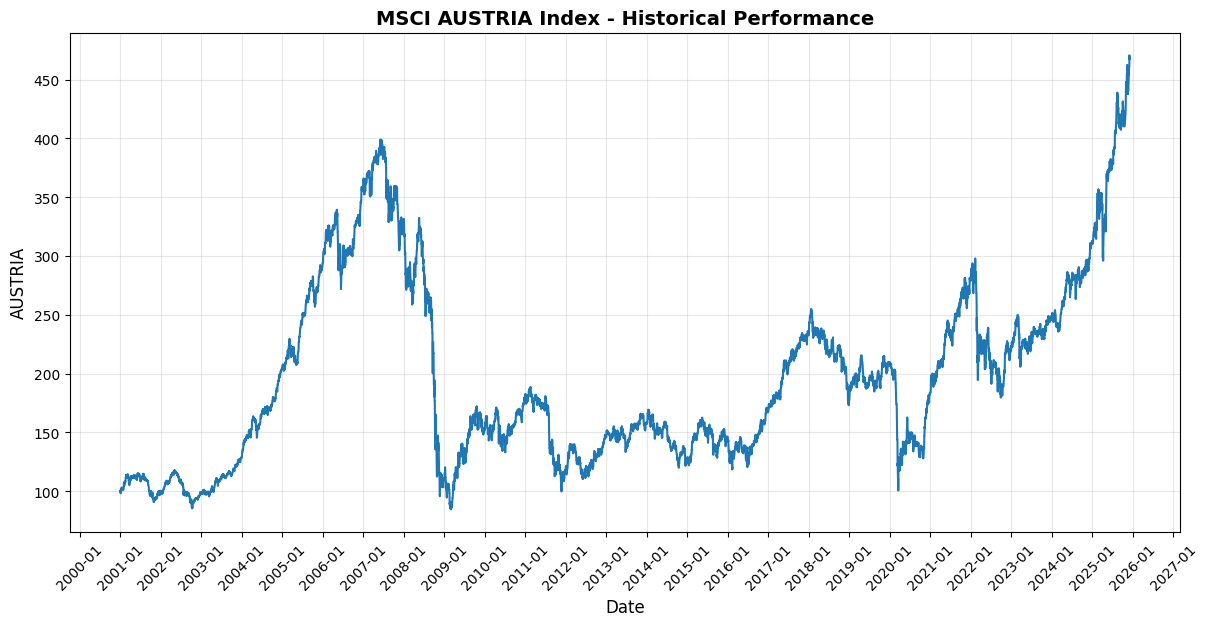


Processing BELGIUM...
Download successful (size: 191367 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'BELGIUM']

First few rows:
         Date    BELGIUM
0  2000-12-29  89.173251
1  2001-01-01  89.173251
2  2001-01-02  89.549196
3  2001-01-03  87.671795
4  2001-01-04  87.976991

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date       0
BELGIUM    0
dtype: int64

Saved to: data/msci/BELGIUM.csv
Final shape: (9106, 2)
Plot saved to: data/msci/BELGIUM_plot.png


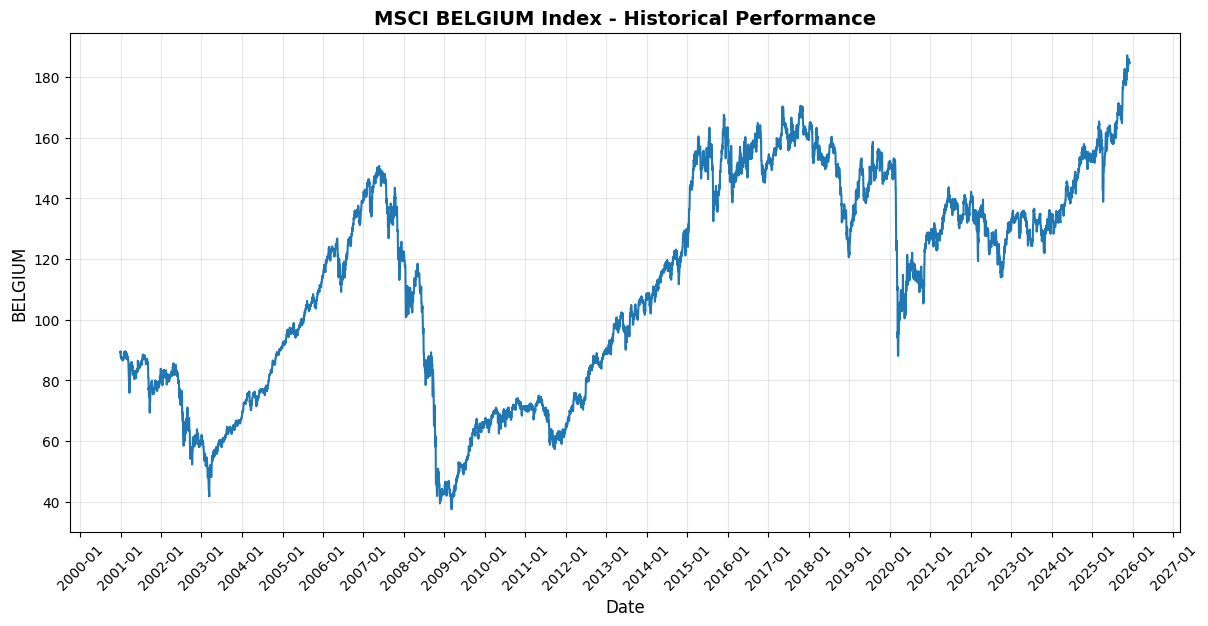


Processing PORTUGAL...
Download successful (size: 189042 bytes)

Original data shape: (6504, 2)
Columns: ['Date', 'PORTUGAL']

First few rows:
         Date    PORTUGAL
0  2000-12-29  102.232891
1  2001-01-01  102.232891
2  2001-01-02  102.450644
3  2001-01-03  102.036359
4  2001-01-04  103.882858

Using 'Date' as date column

Date range: 2000-12-29 00:00:00 to 2025-12-03 00:00:00
Total rows: 6504
Expected daily rows: 9106
Missing days: 2602

After filling missing days:
Total rows: 9106
Missing values per column:
Date        0
PORTUGAL    0
dtype: int64

Saved to: data/msci/PORTUGAL.csv
Final shape: (9106, 2)
Plot saved to: data/msci/PORTUGAL_plot.png


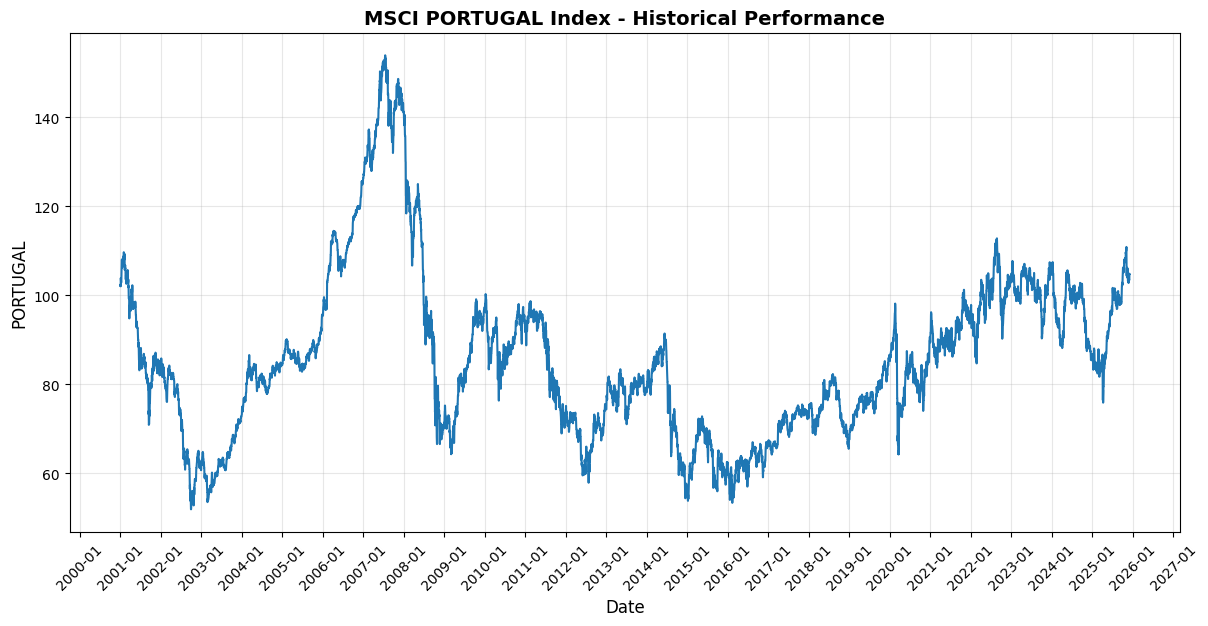

In [5]:
# Download and process each file
for index_name, file_path in files_to_download.items():
    print(f"\n{'='*60}")
    print(f"Processing {index_name}...")
    print(f"{'='*60}")
    
    # Construct the full URL
    file_url = f"{github_base_url}/{file_path}"
    print(f"Downloading from: {file_url}")
    
    # Download the file
    try:
        response = requests.get(file_url)
        response.raise_for_status()
        print(f"Download successful (size: {len(response.content)} bytes)")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
        continue
    
    # Read CSV into pandas
    df = pd.read_csv(StringIO(response.text))
    print(f"\nOriginal data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(df.head())
    
    # Identify the date column (common names: Date, DATE, date, TIME_PERIOD, etc.)
    date_col = None
    for col in df.columns:
        if col.lower() in ['date', 'time_period', 'time', 'timestamp']:
            date_col = col
            break
    
    if date_col is None:
        print(f"Warning: Could not identify date column. Assuming first column is date.")
        date_col = df.columns[0]
    
    print(f"\nUsing '{date_col}' as date column")
    
    # Convert date column to datetime
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    # Check for missing dates
    print(f"\nDate range: {df[date_col].min()} to {df[date_col].max()}")
    print(f"Total rows: {len(df)}")
    
    # Create a complete date range (daily)
    date_range = pd.date_range(start=df[date_col].min(), end=df[date_col].max(), freq='D')
    print(f"Expected daily rows: {len(date_range)}")
    print(f"Missing days: {len(date_range) - len(df)}")
    
    # Set date as index
    df_indexed = df.set_index(date_col)
    
    # Reindex to include all days
    df_complete = df_indexed.reindex(date_range)
    
    # Apply backward fill (bfill) to fill missing days
    df_filled = df_complete.bfill()
    
    # Reset index to have date as a column again
    df_filled = df_filled.reset_index()
    df_filled = df_filled.rename(columns={'index': date_col})
    
    print(f"\nAfter filling missing days:")
    print(f"Total rows: {len(df_filled)}")
    print(f"Missing values per column:")
    print(df_filled.isnull().sum())
    
    # Save to output directory
    output_file = os.path.join(output_dir, f"{index_name}.csv")
    df_filled.to_csv(output_file, index=False)
    print(f"\nSaved to: {output_file}")
    print(f"Final shape: {df_filled.shape}")
    
    # Identify the value column (first numeric column that is not the date)
    value_col = None
    for col in df_filled.columns:
        if col != date_col and pd.api.types.is_numeric_dtype(df_filled[col]):
            value_col = col
            break
    
    if value_col is None:
        print(f"Warning: Could not identify value column for plotting.")
    else:
        # Create plot
        plt.figure(figsize=(12, 6))
        plt.plot(df_filled[date_col], df_filled[value_col], linewidth=1.5)
        plt.title(f'MSCI {index_name} Index - Historical Performance', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel(f'{value_col}', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Format x-axis dates
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.xticks(rotation=45)
        
        # Save plot
        plot_file = os.path.join(output_dir, f"{index_name}_plot.png")
        plt.savefig(plot_file, dpi=150, bbox_inches='tight')
        print(f"Plot saved to: {plot_file}")
        
        plt.show()
